In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Subset,DataLoader
import torch.optim as optim
import torchvision.datasets as datasets

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ,transforms.Resize((128, 128))
])

In [4]:

train_dataset=datasets.CelebA(
    root="C:/Users/maddo/Downloads/COdes from Work/Working on now",split='train',target_type='attr',transform=transform,download=True)

Files already downloaded and verified


In [5]:
train_dataset


Dataset CelebA
    Number of datapoints: 162770
    Root location: C:/Users/maddo/Downloads/COdes from Work/Working on now
    Target type: ['attr']
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99869996..1.0].


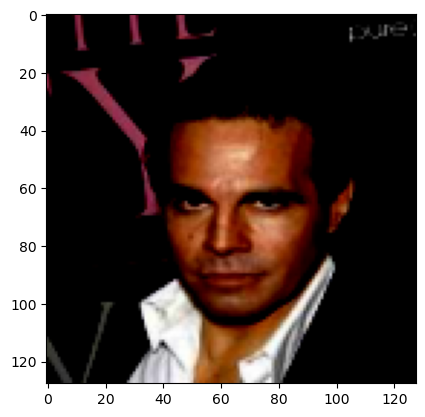

In [6]:
plt.imshow(train_dataset[7][0].permute(1, 2, 0))

In [7]:
train_dataset[0][0].shape

torch.Size([3, 128, 128])

In [8]:
train_loader = DataLoader(Subset(train_dataset, range(20000)), batch_size=100,shuffle=True )

In [9]:
class encoder1(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1=nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(5,5),stride=2,padding=1)
        self.cnn2=nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(7,7),stride=2,padding=1)
        self.bn=nn.BatchNorm2d(10)
        self.bn2=nn.BatchNorm2d(20)
        self.fc11=nn.Linear(20*30*30,1000)
        self.fc12=nn.Linear(20*30*30,1000)
        self.fc21=nn.Linear(1000,5000)
        self.fc22=nn.Linear(1000,5000)
        self.fc31=nn.Linear(5000,40)
        self.fc32=nn.Linear(5000,40)
        self.sigm=nn.ReLU()
    def forward(self,x):
        x=self.cnn1(x)
        x=self.bn(x)
        x=self.cnn2(x)
        x=self.bn2(x)
        x=x.view(x.shape[0],-1)
        y=self.sigm(self.fc12(x))
        y=self.sigm(self.fc22(y))
        y=self.fc32(y)
        x=self.sigm(self.fc11(x))
        x=self.sigm(self.fc21(x))
        x=self.fc31(x)
        mean=x
        stddev=y
        return mean,stddev
        

In [10]:
def sampling(x,y):
    u=torch.exp(0.5*y)
    epsilon=torch.randn_like(y)
    return x+epsilon*u

In [11]:
class decoder2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(40,1000)
        self.fc2=nn.Linear(1000,4000)
        self.fc3=nn.Linear(4000,128*128*3)
        self.sigm=nn.ReLU()

    def forward(self,x,y):
        x=sampling(x,y)
        x=self.sigm(self.fc1(x))
        x=self.sigm(self.fc2(x))
        x=self.fc3(x)
        return x

In [12]:
enc1=encoder1()
dec1=decoder2()

In [13]:
encdevice=enc1.to('cuda')
decdevice=dec1.to('cuda')

In [14]:
criterion=nn.MSELoss(reduction='mean')

In [15]:
optimizer=optim.Adam(list(enc1.parameters())+list(dec1.parameters()),lr=0.001)

In [16]:
epoch=10

In [17]:
for i in range(epoch):
    ind=0
    for x,y in train_loader:

            bthsize=len(x)
            x=x.to('cuda')
            y=y.to('cuda')
            latmean,latstd=encdevice(x)
            latstd=latstd.clamp(min=-10,max=10)
            out=decdevice(latmean,latstd)
            
            KLD = -0.5 * torch.mean(1 + latstd - latmean.pow(2) - latstd.exp())
            Beta=0.005
            val=2
            if i<=val:
                Beta=0
            else:
                Beta=(i-val)*0.001

            x=x.view(x.shape[0],-1)
            reconloss=criterion(out,x)
            
            loss=reconloss+Beta*KLD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ind+=1
            print(f"epoch number{i} index {ind}, recon loss is {reconloss.item()} and KLD is {KLD.item()} and total loss is {loss.item()}")


epoch number0 index 1, recon loss is 0.36722058057785034 and KLD is 0.008419078774750233 and total loss is 0.36722058057785034
epoch number0 index 2, recon loss is 0.5635089874267578 and KLD is 12.82761001586914 and total loss is 0.5635089874267578
epoch number0 index 3, recon loss is 0.3521254062652588 and KLD is 4.644199848175049 and total loss is 0.3521254062652588
epoch number0 index 4, recon loss is 0.37071648240089417 and KLD is 9.691094398498535 and total loss is 0.37071648240089417
epoch number0 index 5, recon loss is 0.3533128499984741 and KLD is 4.974429130554199 and total loss is 0.3533128499984741
epoch number0 index 6, recon loss is 0.3210411071777344 and KLD is 5.689964294433594 and total loss is 0.3210411071777344
epoch number0 index 7, recon loss is 0.3402436077594757 and KLD is 10.032327651977539 and total loss is 0.3402436077594757
epoch number0 index 8, recon loss is 0.2975977957248688 and KLD is 6.427297592163086 and total loss is 0.2975977957248688
epoch number0 in

In [76]:

subj=train_dataset[0][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0000001].


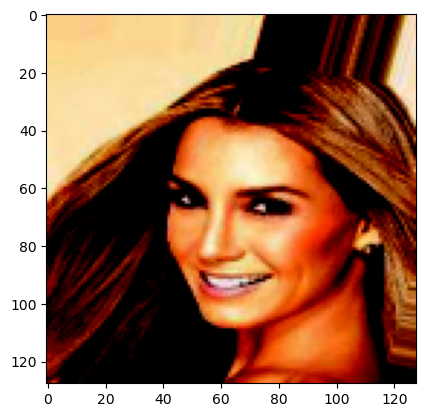

In [77]:
plt.imshow(subj.permute(1, 2, 0))

In [78]:
subj=subj.to('cuda')
outm,outstd=encdevice(subj.unsqueeze(0))

In [79]:
outm

tensor([[-0.0721, -0.2575, -0.8012,  0.7586,  0.1131, -0.2817, -0.4038,  0.6185,
         -0.9507, -0.2213, -0.3938, -0.1352, -0.3285, -0.0114,  0.4225,  0.8398,
         -0.6018,  0.5248,  1.0262,  0.1221,  0.1951,  0.9153,  1.0313,  0.5473,
          0.7006,  0.4379, -1.4936, -0.0501, -0.3887, -0.3979,  1.5023,  0.6874,
         -0.4467, -0.2271,  0.3245, -0.9482,  0.8931,  0.7200, -0.6230, -0.5693]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [80]:
outstd

tensor([[-125.1256, -103.1289,  -55.9759, -121.9207,  -72.7902, -327.9880,
          -66.5539, -113.7680, -103.5311,  -76.0861,  -97.1878, -120.3742,
          -88.3402, -120.1844, -122.0992,  -74.4234, -110.7248, -104.9611,
         -104.1212,  -74.9234, -104.2289, -106.7661, -121.3949,  -88.7767,
         -115.4533, -149.8921, -131.8462, -130.5793, -120.8852, -147.4306,
         -126.4570, -166.6677, -120.9979,  -86.0519, -108.2612, -100.6263,
         -107.8590,  -92.7916, -124.0317, -116.4985]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [81]:
final=decdevice(outm,outstd)

In [82]:
final.shape

torch.Size([1, 49152])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0424697..1.0562078].


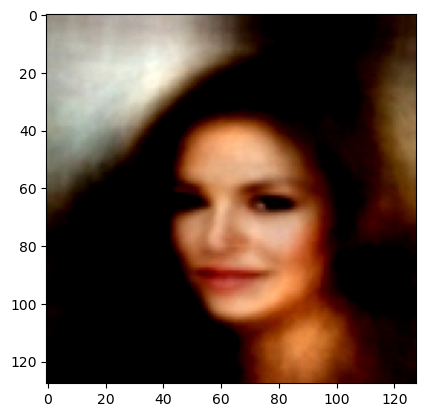

In [83]:
rep=final.detach().to('cpu')
rep = rep.view(3, 128, 128)
rep = rep.permute(1, 2, 0) 
plt.imshow(rep)